In [222]:
#Importing Libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from tqdm import tqdm
import wandb
from torch.utils.data import Subset
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [223]:

def ReadingStockCSV(filename):
    """
    Read a stock CSV file and return a formatted DataFrame.
    
    Parameters:
    - filename: string, path to the stock CSV file
    
    Returns:
    - df: DataFrame, formatted stock data
    """
    # Reading the file
    df = pd.read_csv(filename, sep=",", header=None)
    
    # Assigning headers to the DataFrame
    df.columns = ["Timestamp", "Open", "High", "Low", "Close", "Volume"]
    
    # Converting the Timestamp column to datetime format
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    
    return df


In [224]:
# Reading the file
DRE_1minTXT = "/home/cminds/CMInDS/Uddeshya/sp500_tickers_A-D_1min_1pppix/DGX_1min.txt"

DRE_1min = ReadingStockCSV(DRE_1minTXT)


DRE_1min.head()

,Timestamp,Open,High,Low,Close,Volume
0,2005-01-03 09:30:00,37.1719,37.1719,37.1563,37.1719,12800
1,2005-01-03 09:31:00,37.1757,37.1757,37.1757,37.1757,3600
2,2005-01-03 09:32:00,37.1757,37.2146,37.1757,37.2146,3800
3,2005-01-03 09:33:00,37.1835,37.1874,37.1796,37.1796,3200
4,2005-01-03 09:34:00,37.1757,37.1796,37.1408,37.1641,10000


In [225]:
# def CloseChange(df):
#     """
#     Add 'prev_close' and 'close_change' columns to the stock DataFrame.

#     Parameters:
#     - df: DataFrame, stock data with columns including 'Close'

#     Returns:
#     - df: DataFrame, stock data with added columns 'prev_close' and 'close_change'
#     """
#     df["prev_close"] = df.shift(1)["Close"]
#     df["close_change"] = df['Close'] - df['prev_close']
#     df["close_change"].fillna(0, inplace=True)
#     df.drop(columns='prev_close' , inplace=True)
    
#     return df


In [226]:
# DRE_1min = CloseChange(DRE_1min)
# DRE_1min.head()

In [227]:
def stockRelevant(df):
    """
    Filter the stock data to keep only the rows that fall within the US stock market trading hours.

    Parameters:
    - df: DataFrame, stock data with a 'Timestamp' column

    Returns:
    - df: DataFrame, filtered stock data
    """
    # Filtering for weekdays (Monday=0, Sunday=6)
    df = df[df['Timestamp'].dt.weekday < 5]
    
    # Filtering for trading hours (9:30 AM to 4:00 PM Eastern Time)
    df = df[(df['Timestamp'].dt.time >= pd.Timestamp('09:30:00').time()) & 
            (df['Timestamp'].dt.time <= pd.Timestamp('16:00:00').time())]
    
    return df


In [228]:
DRE_1min = stockRelevant(DRE_1min)
DRE_1min.head()

,Timestamp,Open,High,Low,Close,Volume
0,2005-01-03 09:30:00,37.1719,37.1719,37.1563,37.1719,12800
1,2005-01-03 09:31:00,37.1757,37.1757,37.1757,37.1757,3600
2,2005-01-03 09:32:00,37.1757,37.2146,37.1757,37.2146,3800
3,2005-01-03 09:33:00,37.1835,37.1874,37.1796,37.1796,3200
4,2005-01-03 09:34:00,37.1757,37.1796,37.1408,37.1641,10000


In [229]:
def finalStockData(df):
    """
    Clean the stock data to handle missing values, duplicates, and other potential issues.

    Parameters:
    - df: DataFrame, stock data with a 'Timestamp' column

    Returns:
    - df: DataFrame, cleaned stock data
    """
    
    # 1. Handle missing values
    # For this example, we will fill missing values with the forward fill method.
    # This can be adapted based on the specific nature and needs of the data.
    df.fillna(method='backfill', inplace=True)
    
    # 2. Remove duplicate rows
    df.drop_duplicates(inplace=True)
    
    # 3. Ensure the data is sorted by 'Timestamp'
    df.sort_values(by='Timestamp', inplace=True)
    
    # 4. Any additional cleaning steps can be added here.
    # (For now, we will stick to the above three)

    return df


In [230]:

DRE_1min = finalStockData(DRE_1min)
DRE_1min[:10]

,Timestamp,Open,High,Low,Close,Volume
0,2005-01-03 09:30:00,37.1719,37.1719,37.1563,37.1719,12800
1,2005-01-03 09:31:00,37.1757,37.1757,37.1757,37.1757,3600
2,2005-01-03 09:32:00,37.1757,37.2146,37.1757,37.2146,3800
3,2005-01-03 09:33:00,37.1835,37.1874,37.1796,37.1796,3200
4,2005-01-03 09:34:00,37.1757,37.1796,37.1408,37.1641,10000
5,2005-01-03 09:35:00,37.1680,37.2729,37.1641,37.2534,17400
6,2005-01-03 09:36:00,37.2729,37.2884,37.2340,37.2340,2400
7,2005-01-03 09:37:00,37.2534,37.2534,37.2534,37.2534,200
8,2005-01-03 09:38:00,37.2185,37.2224,37.2185,37.2224,1400
9,2005-01-03 09:39:00,37.2262,37.2340,37.2262,37.2340,3200


In [231]:
def split_data(dataframe, start_date, validation_duration_years=2, test_duration_years=2):
   
    
    # Filter data to only include rows from start_date onward
    dataframe = dataframe[dataframe['Timestamp'] >= start_date]
    
    # Determine the cutoff dates for the training and validation data
    test_cutoff_date = dataframe['Timestamp'].max() - pd.DateOffset(years=test_duration_years)
    validation_cutoff_date = test_cutoff_date - pd.DateOffset(years=validation_duration_years)

    # Split the data into training, validation, and testing based on the cutoff dates
    train_data = dataframe[dataframe['Timestamp'] <= validation_cutoff_date]
    validation_data = dataframe[(dataframe['Timestamp'] > validation_cutoff_date) & (dataframe['Timestamp'] <= test_cutoff_date)]
    test_data = dataframe[dataframe['Timestamp'] > test_cutoff_date]
    
    return train_data, validation_data, test_data

In [232]:
DREtrain_data, DREvalidation_data, DREtest_data = split_data(DRE_1min,start_date="2007-01-12")

In [233]:
print(DREtrain_data[:10])
print(DREtrain_data[:10])

                 Timestamp     Open     High      Low    Close  Volume
187091 2007-01-12 09:30:00  39.8808  39.9045  39.6993  39.7151   34300
187092 2007-01-12 09:31:00  39.7072  39.7624  39.6993  39.6993    6400
187093 2007-01-12 09:32:00  39.7308  39.7703  39.7072  39.7387    4500
187094 2007-01-12 09:33:00  39.7466  39.8808  39.7466  39.8413    4700
187095 2007-01-12 09:34:00  39.8571  39.9045  39.7782  39.8256    3200
187096 2007-01-12 09:35:00  39.8413  39.9360  39.8287  39.9360    9800
187097 2007-01-12 09:36:00  39.9360  40.0229  39.9203  39.9282   10200
187098 2007-01-12 09:37:00  39.9282  39.9597  39.9282  39.9439    3000
187099 2007-01-12 09:38:00  39.9518  40.0229  39.8966  39.9676    5600
187100 2007-01-12 09:39:00  39.9692  39.9692  39.8966  39.9360    3100
                 Timestamp     Open     High      Low    Close  Volume
187091 2007-01-12 09:30:00  39.8808  39.9045  39.6993  39.7151   34300
187092 2007-01-12 09:31:00  39.7072  39.7624  39.6993  39.6993    6400
187093

In [234]:
print(DREvalidation_data[:10])
print(DREvalidation_data[:10])

                  Timestamp     Open     High      Low    Close  Volume
1245160 2018-02-26 09:30:00  94.6918  94.9315  94.6365  94.9315   11167
1245161 2018-02-26 09:31:00  94.8670  95.0236  94.8485  94.8577    3231
1245162 2018-02-26 09:33:00  94.9038  94.9223  94.7564  94.9038    2900
1245163 2018-02-26 09:35:00  95.0329  95.0605  95.0329  95.0605    1100
1245164 2018-02-26 09:36:00  95.1988  95.1988  95.1757  95.1757     200
1245165 2018-02-26 09:37:00  95.1066  95.1066  95.1066  95.1066     100
1245166 2018-02-26 09:38:00  94.9637  95.0882  94.8577  94.8577     445
1245167 2018-02-26 09:39:00  94.8577  94.8670  94.8117  94.8117     999
1245168 2018-02-26 09:40:00  94.8670  94.8670  94.7103  94.7287     700
1245169 2018-02-26 09:41:00  94.6550  94.6550  94.5720  94.6550     600
                  Timestamp     Open     High      Low    Close  Volume
1245160 2018-02-26 09:30:00  94.6918  94.9315  94.6365  94.9315   11167
1245161 2018-02-26 09:31:00  94.8670  95.0236  94.8485  94.8577 

In [235]:
print(DREtest_data[:10])
print(DREtest_data[:10])

                  Timestamp      Open      High       Low     Close  Volume
1426847 2020-02-26 09:30:00  106.7353  106.7353  106.5719  106.5767   12341
1426848 2020-02-26 09:31:00  106.6776  106.7833  106.5335  106.5335    1434
1426849 2020-02-26 09:33:00  106.4903  106.6344  106.4903  106.6200    1100
1426850 2020-02-26 09:34:00  106.6200  106.7737  106.6200  106.6680     800
1426851 2020-02-26 09:35:00  106.6296  106.8121  106.6296  106.7449    1800
1426852 2020-02-26 09:36:00  106.7641  106.9659  106.7641  106.9659     800
1426853 2020-02-26 09:37:00  106.9563  107.0523  106.9467  107.0523     300
1426854 2020-02-26 09:38:00  107.0620  107.0620  106.9274  107.0139     300
1426855 2020-02-26 09:39:00  107.0620  107.0620  107.0427  107.0620    1035
1426856 2020-02-26 09:40:00  107.0716  107.0716  106.9947  107.0427     600
                  Timestamp      Open      High       Low     Close  Volume
1426847 2020-02-26 09:30:00  106.7353  106.7353  106.5719  106.5767   12341
1426848 2020

In [236]:
def DividingDF(df):
    """
    Divide the stock data into two separate DataFrames: one for timestamps and the other for training data.

    Parameters:
    - df: DataFrame, cleaned stock data with a 'Timestamp' column

    Returns:
    - timestamp_df: DataFrame, containing only the 'Timestamp' column
    - stockTrainingDF: DataFrame, containing all other columns with float type values
    """
    
    # Create the timestamp DataFrame
    timestamp_df = df[['Timestamp']]
    
    # Create the stock training DataFrame and drop the 'Timestamp' column
    stockTrainingDF = df.drop(columns=['Timestamp'])
    #stockTrainingDF = df.drop(columns=['prev_close'])
    
    # Convert all columns in stockTrainingDF to float type
    for col in stockTrainingDF.columns:
        stockTrainingDF[col] = stockTrainingDF[col].astype(float)
    
    return timestamp_df, stockTrainingDF


In [237]:
DREtrain_time,DREtrain_modelData = DividingDF(DREtrain_data)
DREtrain_time.head(),DREtrain_modelData.head()



(                 Timestamp
 187091 2007-01-12 09:30:00
 187092 2007-01-12 09:31:00
 187093 2007-01-12 09:32:00
 187094 2007-01-12 09:33:00
 187095 2007-01-12 09:34:00,
            Open     High      Low    Close   Volume
 187091  39.8808  39.9045  39.6993  39.7151  34300.0
 187092  39.7072  39.7624  39.6993  39.6993   6400.0
 187093  39.7308  39.7703  39.7072  39.7387   4500.0
 187094  39.7466  39.8808  39.7466  39.8413   4700.0
 187095  39.8571  39.9045  39.7782  39.8256   3200.0)

In [238]:
DREvalid_time,DREvalid_modelData = DividingDF(DREvalidation_data)
DREvalid_time.head(),DREvalid_modelData.head()

(                  Timestamp
 1245160 2018-02-26 09:30:00
 1245161 2018-02-26 09:31:00
 1245162 2018-02-26 09:33:00
 1245163 2018-02-26 09:35:00
 1245164 2018-02-26 09:36:00,
             Open     High      Low    Close   Volume
 1245160  94.6918  94.9315  94.6365  94.9315  11167.0
 1245161  94.8670  95.0236  94.8485  94.8577   3231.0
 1245162  94.9038  94.9223  94.7564  94.9038   2900.0
 1245163  95.0329  95.0605  95.0329  95.0605   1100.0
 1245164  95.1988  95.1988  95.1757  95.1757    200.0)

In [239]:
DREtest_time,DREtest_modelData = DividingDF(DREtest_data)
DREtest_time.head(),DREtest_modelData.head()

(                  Timestamp
 1426847 2020-02-26 09:30:00
 1426848 2020-02-26 09:31:00
 1426849 2020-02-26 09:33:00
 1426850 2020-02-26 09:34:00
 1426851 2020-02-26 09:35:00,
              Open      High       Low     Close   Volume
 1426847  106.7353  106.7353  106.5719  106.5767  12341.0
 1426848  106.6776  106.7833  106.5335  106.5335   1434.0
 1426849  106.4903  106.6344  106.4903  106.6200   1100.0
 1426850  106.6200  106.7737  106.6200  106.6680    800.0
 1426851  106.6296  106.8121  106.6296  106.7449   1800.0)

In [240]:
from sklearn.preprocessing import StandardScaler

def fit_and_transform_data(train_data, valid_data, test_data):
    scaler = StandardScaler()
    
    # Fit the scaler using only the training data
    scaler.fit(train_data)
    
    # Transform all three datasets using the fitted scaler
    train_transformed = scaler.transform(train_data)
    valid_transformed = scaler.transform(valid_data)
    test_transformed = scaler.transform(test_data)
    
    # Convert the numpy arrays back to DataFrames for better readability
    train_df = pd.DataFrame(train_transformed, columns=train_data.columns)
    valid_df = pd.DataFrame(valid_transformed, columns=valid_data.columns)
    test_df = pd.DataFrame(test_transformed, columns=test_data.columns)
    
    return train_df, valid_df, test_df, scaler


In [241]:
DREtrain_scaled, DREvalid_scaled, DREtest_scaled, scaler = fit_and_transform_data(DREtrain_modelData, DREvalid_modelData, DREtest_modelData)

In [242]:
DREtrain_scaled[:10]

,Open,High,Low,Close,Volume
0,-0.843699,-0.843081,-0.854224,-0.854110,4.024466
1,-0.854615,-0.852016,-0.854224,-0.855103,0.397004
2,-0.853131,-0.851519,-0.853727,-0.852626,0.149973
3,-0.852137,-0.844572,-0.851249,-0.846174,0.175976
4,-0.845189,-0.843081,-0.849262,-0.847161,-0.019049
5,-0.846183,-0.841101,-0.846087,-0.840219,0.839060
6,-0.840228,-0.835637,-0.840326,-0.840710,0.891067
7,-0.840718,-0.839611,-0.839829,-0.839723,-0.045052
8,-0.839234,-0.835637,-0.841817,-0.838232,0.292991
9,-0.838140,-0.839013,-0.841817,-0.840219,-0.032050


In [243]:
DREvalid_scaled[:10]

,Open,High,Low,Close,Volume
0,2.602846,2.616809,2.600501,2.617936,1.016793
1,2.613863,2.622600,2.613832,2.613295,-0.015018
2,2.616177,2.616230,2.608041,2.616194,-0.058054
3,2.624295,2.624920,2.625428,2.626047,-0.292083
4,2.634727,2.633616,2.634408,2.633291,-0.409098
5,2.628929,2.627818,2.630063,2.628946,-0.422100
6,2.619944,2.626661,2.614411,2.613295,-0.377244
7,2.613278,2.612753,2.611518,2.610403,-0.305215
8,2.613863,2.612753,2.605142,2.605184,-0.344090
9,2.600532,2.599424,2.596445,2.600549,-0.357092


In [244]:
DREtest_scaled[:10]

,Open,High,Low,Close,Volume
0,3.360148,3.358987,3.351058,3.350194,1.169432
1,3.356520,3.362005,3.348643,3.347478,-0.248658
2,3.344743,3.352643,3.345927,3.352917,-0.292083
3,3.352898,3.361402,3.354083,3.355935,-0.331088
4,3.353502,3.363816,3.354687,3.360771,-0.201072
5,3.361959,3.373486,3.363145,3.374667,-0.331088
6,3.374045,3.378919,3.374627,3.380100,-0.396097
7,3.380691,3.379529,3.373414,3.377685,-0.396097
8,3.380691,3.379529,3.380664,3.380710,-0.300534
9,3.381295,3.380132,3.377646,3.379496,-0.357092


In [245]:
# from sklearn.preprocessing import StandardScaler

# def DataStand_Norm(stockTrainingDF):
  
    
#     scaler = StandardScaler()
#     standardized_values = scaler.fit_transform(stockTrainingDF)
    
#     # Convert the numpy array back to DataFrame for better readability
#     standardized_df = pd.DataFrame(standardized_values, columns=stockTrainingDF.columns)
    
#     return standardized_df, scaler


In [246]:
# DRE_modelData_scaled , DREscalar = DataStand_Norm(DRE_modelData)
# DRE_modelData_scaled[:10]

In [247]:
# Correcting the InverseStandardization function to handle numpy arrays
def InverseStandardization(standardized_data, scaler, columns):
   
    
    original_values = scaler.inverse_transform(standardized_data)
    
    # Convert the numpy array back to DataFrame for better readability
    original_df = pd.DataFrame(original_values, columns=columns)
    
    return original_df


In [248]:


# Using the function to revert the standardized data
original_df = InverseStandardization(DREvalid_scaled , scaler, columns = DREtest_scaled.columns)
original_df.head()


,Open,High,Low,Close,Volume
0,94.6918,94.9315,94.6365,94.9315,11167.0
1,94.8670,95.0236,94.8485,94.8577,3231.0
2,94.9038,94.9223,94.7564,94.9038,2900.0
3,95.0329,95.0605,95.0329,95.0605,1100.0
4,95.1988,95.1988,95.1757,95.1757,200.0


In [249]:
def upscale_predicted(prediction,scalar):
    mean = scalar.mean_[3]
    std =  scalar.scale_[3]
    original_values = prediction * std + mean
    original_pred = pd.DataFrame(original_values)

    return original_pred

In [250]:
def generate_sequences(df, n_past=5, n_future=1):
    """
    Generate sequences using the sliding window technique.

    Parameters:
    - df: DataFrame, scaled data for which sequences need to be generated.
    - n_past: int, number of past days we want to use to predict the future.
    - n_future: int, number of days we want to look into the future based on the past days.

    Returns:
    - trainX: numpy array, input sequences
    - trainY: numpy array, target values for each sequence
    """
    
    # Convert the DataFrame to numpy array for efficient slicing
    df_for_training_scaled = df.values
    
    batchX = []
    batchY = []

    for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
        batchX.append(df_for_training_scaled[i - n_past:i, 0:df.shape[1]])
        batchY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 3])

    batchX, batchY = np.array(batchX), np.array(batchY)
    
    return batchX, batchY


In [251]:
trainX, trainY = generate_sequences(DREtrain_scaled, n_past=7, n_future=1)
trainX[0],trainY[0]

(array([[-0.84369874, -0.8430814 , -0.85422382, -0.85410972,  4.02446553],
        [-0.8546148 , -0.85201611, -0.85422382, -0.85510324,  0.39700425],
        [-0.85313082, -0.85151939, -0.85372703, -0.85262574,  0.14997284],
        [-0.85213731, -0.84457157, -0.85124936, -0.84617418,  0.17597614],
        [-0.84518901, -0.8430814 , -0.84926219, -0.84716141, -0.01904866],
        [-0.84618252, -0.8411008 , -0.8460865 , -0.84021938,  0.83906046],
        [-0.84022773, -0.83563686, -0.84032624, -0.84070985,  0.89106708]]),
 array([-0.83972262]))

In [252]:
trainX, trainY = generate_sequences(DREtrain_scaled, n_past=7, n_future=1)
trainX[0],trainY[0]

(array([[-0.84369874, -0.8430814 , -0.85422382, -0.85410972,  4.02446553],
        [-0.8546148 , -0.85201611, -0.85422382, -0.85510324,  0.39700425],
        [-0.85313082, -0.85151939, -0.85372703, -0.85262574,  0.14997284],
        [-0.85213731, -0.84457157, -0.85124936, -0.84617418,  0.17597614],
        [-0.84518901, -0.8430814 , -0.84926219, -0.84716141, -0.01904866],
        [-0.84618252, -0.8411008 , -0.8460865 , -0.84021938,  0.83906046],
        [-0.84022773, -0.83563686, -0.84032624, -0.84070985,  0.89106708]]),
 array([-0.83972262]))

In [253]:
trainX, trainY = generate_sequences(DREtrain_scaled, n_past=7, n_future=1)
trainX[0].shape,trainY[0].shape

((7, 5), (1,))

In [254]:
validX, validY = generate_sequences(DREvalid_scaled, n_past=7, n_future=1)
validX[0],validY[0]

(array([[ 2.60284648,  2.61680878,  2.60050083,  2.61793574,  1.01679307],
        [ 2.61386315,  2.62259968,  2.61383245,  2.61329515, -0.01501814],
        [ 2.61617715,  2.61623032,  2.60804074,  2.61619395, -0.05805362],
        [ 2.62429503,  2.62491982,  2.62542844,  2.62604735, -0.29208338],
        [ 2.63472691,  2.6336156 ,  2.63440841,  2.63329121, -0.40909826],
        [ 2.62892932,  2.62781841,  2.63006306,  2.62894615, -0.42209991],
        [ 2.6199437 ,  2.62666149,  2.61441099,  2.61329515, -0.37724421]]),
 array([2.61040263]))

In [255]:
validX[0] , validY[0]

(array([[ 2.60284648,  2.61680878,  2.60050083,  2.61793574,  1.01679307],
        [ 2.61386315,  2.62259968,  2.61383245,  2.61329515, -0.01501814],
        [ 2.61617715,  2.61623032,  2.60804074,  2.61619395, -0.05805362],
        [ 2.62429503,  2.62491982,  2.62542844,  2.62604735, -0.29208338],
        [ 2.63472691,  2.6336156 ,  2.63440841,  2.63329121, -0.40909826],
        [ 2.62892932,  2.62781841,  2.63006306,  2.62894615, -0.42209991],
        [ 2.6199437 ,  2.62666149,  2.61441099,  2.61329515, -0.37724421]]),
 array([2.61040263]))

In [256]:
testX, testY = generate_sequences(DREtest_scaled, n_past=7, n_future=1)
testX[0],testY[:5]

(array([[ 3.36014825,  3.3589872 ,  3.35105821,  3.35019398,  1.16943248],
        [ 3.35652004,  3.36200526,  3.34864342,  3.34747753, -0.24865785],
        [ 3.34474252,  3.35264299,  3.34592679,  3.35291671, -0.29208338],
        [ 3.35289812,  3.36140165,  3.35408297,  3.35593499, -0.33108834],
        [ 3.35350177,  3.3638161 ,  3.35468667,  3.36077051, -0.2010718 ],
        [ 3.36195921,  3.37348646,  3.3631447 ,  3.37466715, -0.33108834],
        [ 3.37404485,  3.37891897,  3.3746275 ,  3.38010004, -0.3960966 ]]),
 array([[3.37768542],
        [3.38070998],
        [3.37949638],
        [3.38493556],
        [3.38372825]]))

In [257]:
type(testX)

numpy.ndarray

In [258]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
       
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [259]:
def create_dataloader(data, labels, batch_size=64, shuffle=False, num_workers=0):
 
    dataset = TimeSeriesDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return dataloader


In [260]:

train_loader = create_dataloader(trainX, trainY)
valid_loader = create_dataloader(validX, validY)
test_loader = create_dataloader(testX, testY)

In [261]:
def view_dataloader_contents(dataloader, num_batches=1): 
    
    # Ensure the DataLoader is not empty
    if len(dataloader) == 0:
        print("The DataLoader is empty.")
        return

    # Loop over the DataLoader to fetch and print batches
    for i, (data, labels) in enumerate(dataloader):
        if i >= num_batches:
            break
        print(f"Batch {i+1} Data:")
        print(data[0])
        print(f"Batch {i+1} Labels:")
        print(labels[0])
        print("------")


In [262]:
view_dataloader_contents(train_loader)

Batch 1 Data:
tensor([[-0.8437, -0.8431, -0.8542, -0.8541,  4.0245],
        [-0.8546, -0.8520, -0.8542, -0.8551,  0.3970],
        [-0.8531, -0.8515, -0.8537, -0.8526,  0.1500],
        [-0.8521, -0.8446, -0.8512, -0.8462,  0.1760],
        [-0.8452, -0.8431, -0.8493, -0.8472, -0.0190],
        [-0.8462, -0.8411, -0.8461, -0.8402,  0.8391],
        [-0.8402, -0.8356, -0.8403, -0.8407,  0.8911]])
Batch 1 Labels:
tensor([-0.8397])
------


In [263]:
view_dataloader_contents(valid_loader)

Batch 1 Data:
tensor([[ 2.6028,  2.6168,  2.6005,  2.6179,  1.0168],
        [ 2.6139,  2.6226,  2.6138,  2.6133, -0.0150],
        [ 2.6162,  2.6162,  2.6080,  2.6162, -0.0581],
        [ 2.6243,  2.6249,  2.6254,  2.6260, -0.2921],
        [ 2.6347,  2.6336,  2.6344,  2.6333, -0.4091],
        [ 2.6289,  2.6278,  2.6301,  2.6289, -0.4221],
        [ 2.6199,  2.6267,  2.6144,  2.6133, -0.3772]])
Batch 1 Labels:
tensor([2.6104])
------


In [264]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1, dropout=0.2):
        """
        Initialize the LSTM model.
        
        Parameters:
        - input_dim (int): The number of input features (number of features in your data).
        - hidden_dim (int): The size of the LSTM's hidden states.
        - output_dim (int): The size of the output.
        - n_layers (int): The number of stacked LSTM layers. Default is 1.
        - dropout (float): Dropout probability for the dropout layer. Default is 0.2.
        """
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        """
        Forward pass for the model.
        
        Parameters:
        - x (Tensor): The input data.
        
        Returns:
        - Tensor: The model output.
        """
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output


In [286]:
input_dim = trainX.shape[2]  # Number of features in the data
hidden_dim = 36 # Size of the LSTM's hidden states
output_dim = 1  # Size of the output

model = LSTMModel(input_dim, hidden_dim, output_dim)


In [287]:
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt

# def train_model(model, train_loader, valid_loader, num_epochs, learning_rate=0.001):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)

#     # Define the criterion and optimizer
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     # Lists to store the losses
#     train_losses = []
#     valid_losses = []

#     for epoch in range(num_epochs):
#         # Training
#         model.train()
#         running_loss = 0.0
#         for data, labels in train_loader:
#             data, labels = data.to(device), labels.to(device)
            
#             # Zero the parameter gradients
#             optimizer.zero_grad()
            
#             # Forward pass
#             outputs = model(data)
#             loss = criterion(outputs, labels)
            
#             # Backward pass and optimization
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item()

#         train_losses.append(running_loss / len(train_loader))

#         # Validation
#         model.eval()
#         running_loss = 0.0
#         valid_predictions = []
#         valid_true_values = []
#         with torch.no_grad():
#             for data, labels in valid_loader:
#                 data, labels = data.to(device), labels.to(device)
#                 outputs = model(data)
#                 loss = criterion(outputs, labels)
                
#                 running_loss += loss.item()
                
#                 # Append predictions and ground truth values
#                 # valid_predictions.extend(outputs.detach().cpu().numpy())
#                 # valid_true_values.extend(labels.cpu().numpy())

#         valid_losses.append(running_loss / len(valid_loader))
#         print(f"Epoch {epoch+1}/{num_epochs} => Train loss: {train_losses[-1]:.4f}, Validation loss: {valid_losses[-1]:.4f}")

#     # Plotting Losses
#     plt.figure(figsize=(12, 4))
    
#     plt.subplot(1, 3, 1)
#     plt.plot(train_losses, label="Training Loss")
#     plt.title("Training Loss")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
    
#     plt.subplot(1, 3, 2)
#     plt.plot(valid_losses, label="Validation Loss", color="orange")
#     plt.title("Validation Loss")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
    
#     plt.subplot(1, 3, 3)
#     plt.plot(train_losses, label="Training Loss")
#     plt.plot(valid_losses, label="Validation Loss")
#     plt.title("Combined Losses")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

#     # Plotting Predictions vs. Ground Truth
#     plt.figure(figsize=(12, 5))
#     plt.plot(valid_true_values, label="Ground Truth", color="blue")
#     plt.plot(valid_predictions, label="Predictions", color="red", linestyle="--")
#     plt.title("Ground Truth vs. Predictions on Validation Data")
#     plt.xlabel("Time")
#     plt.ylabel("Value")
#     plt.legend()
#     plt.show()

#     return model, train_losses, valid_losses, valid_true_values, valid_predictions


In [289]:
def train_model(model, train_loader, valid_loader, num_epochs, learning_rate=0.000915):

    
   
    
    # Define the criterion and optimizer
    criterion = nn.MSELoss()
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # weight_decay_value = 1e-5  # You can adjust this value as needed
    optimizer = optim.Adam(model.parameters(), lr=learning_rate )

    
    # Lists to store the losses
    train_losses = []
    valid_losses = []
    # Before starting the training loop
    # valid_true_values = []
    # valid_predictions = []

    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            data, labels = batch
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        print("taining loss:" ,train_loss )
        train_losses.append(train_loss)

       
        model.eval()
        running_loss = 0.0
        valid_predictions = []  # Reset the lists for each epoch
        valid_true_values = []
        with torch.no_grad():
            for batch in valid_loader:
                data, labels = batch
                outputs = model(data)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                # Append predictions and ground truth values inside the loop
                # valid_predictions.extend(outputs.detach().cpu().numpy())
                # valid_true_values.extend(labels.cpu().numpy())

        valid_loss = running_loss / len(valid_loader)
        valid_losses.append(valid_loss)

        print(f"Epoch {epoch+1}/{num_epochs} => Train loss: {train_loss:.4f}, Validation loss: {valid_loss:.4f}")



    # plt.figure(figsize=(12, 5))
    # plt.plot(valid_true_values, label="Ground Truth", color="blue")
    # plt.plot(valid_predictions, label="Predictions", color="red", linestyle="--")
    # plt.title("Ground Truth vs. Predictions on Validation Data")
    # plt.xlabel("Time")
    # plt.ylabel("Value")
    # plt.legend()
    # plt.show()
    # Plotting the losses
    plt.figure(figsize=(12, 4))
    
    # Training loss plot
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    # Validation loss plot
    plt.subplot(1, 3, 2)
    plt.plot(valid_losses, label="Validation Loss", color="orange")
    plt.title("Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    # Combined loss plot
    plt.subplot(1, 3, 3)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(valid_losses, label="Validation Loss")
    plt.title("Combined Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    
    plt.tight_layout()
    plt.show()
    
    return model, train_losses, valid_losses


taining loss: 0.0015525704727921276
Epoch 1/6 => Train loss: 0.0016, Validation loss: 0.1493
taining loss: 0.000544949089235473
Epoch 2/6 => Train loss: 0.0005, Validation loss: 0.0686
taining loss: 0.0002365110797187037
Epoch 3/6 => Train loss: 0.0002, Validation loss: 0.0611
taining loss: 0.00016386038615929382
Epoch 4/6 => Train loss: 0.0002, Validation loss: 0.0511
taining loss: 0.00014893112911902432
Epoch 5/6 => Train loss: 0.0001, Validation loss: 0.0515
taining loss: 0.00013337285590058723
Epoch 6/6 => Train loss: 0.0001, Validation loss: 0.0421


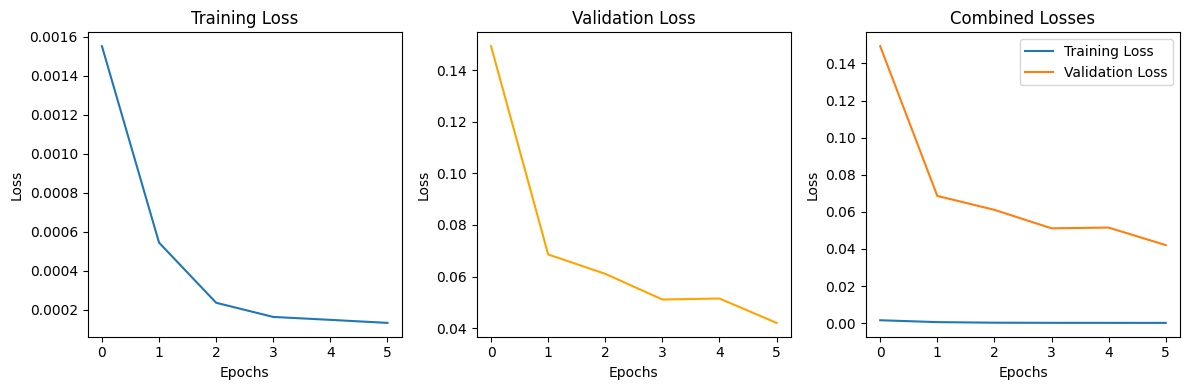

In [290]:
num_epochs = 6
model, train_losses, valid_losses = train_model(model, train_loader, valid_loader, num_epochs)


In [291]:
import matplotlib.pyplot as plt

def validate_and_plot(model, valid_loader):
    """
    Feed the validation set through the trained model to get predictions and plot against ground truth.
    
    Parameters:
    - model (nn.Module): The trained LSTM model.
    - valid_loader (DataLoader): DataLoader for the validation data.
    
    Returns:
    - valid_predictions (list): Predictions for the validation set.
    - valid_true_values (list): Ground truth values for the validation set.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Lists to store the predictions and ground truth values
    valid_predictions = []
    valid_true_values = []

    # Model evaluation mode
    model.eval()
    
    with torch.no_grad():
        for batch in valid_loader:
            data, labels = batch
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            
            # Append predictions and ground truth values
            valid_predictions.extend(outputs.detach().cpu().numpy())
            valid_true_values.extend(labels.cpu().numpy())

    # Plotting Predictions vs. Ground Truth
    plt.figure(figsize=(12, 5))
    plt.plot(valid_true_values, label="Ground Truth", color="blue")
    plt.plot(valid_predictions, label="Predictions", color="red", linestyle="--")
    plt.title("Ground Truth vs. Predictions on Validation Data")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    return valid_predictions, valid_true_values


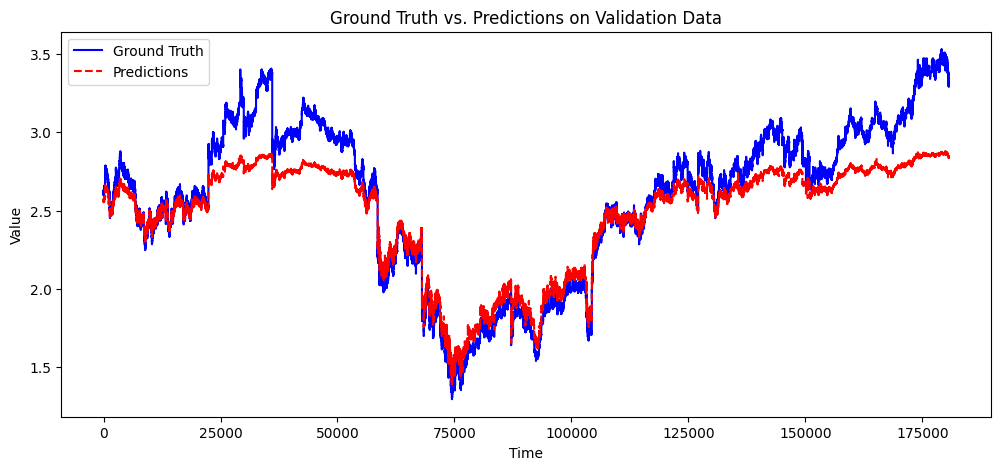

In [292]:
valid_predictions, valid_true_values = validate_and_plot(model, valid_loader)


In [279]:
import matplotlib.pyplot as plt

def plot_predictions_vs_ground_truth(predicted_values, true_values, timestamps, scaler):
    """
    Plot the predicted validation values against the true validation values.
    
    Parameters:
    - predicted_values (numpy.array): Model's predictions on the validation set.
    - true_values (numpy.array): True values from the validation set.
    - timestamps (pandas.Series or list): Corresponding date and time values.
    - scaler (StandardScaler): The scaler object fitted on the training data.
    
    Returns:
    - None, but displays a plot.
    """
    
    # Inverse transform the predicted and true values
    predicted_values_original_scale = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    true_values_original_scale = scaler.inverse_transform(true_values.reshape(-1, 1))
    
    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(timestamps, true_values_original_scale, label="Ground Truth", color="blue")
    plt.plot(timestamps, predicted_values_original_scale, label="Predictions", color="red", linestyle="--")
    plt.title("Predictions vs. Ground Truth on Validation Data")
    plt.xlabel("Date and Time")
    plt.ylabel("Value")
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()


In [272]:
plot_predictions_vs_ground_truth(valid_true_values,valid_predictions)

TypeError: plot_predictions_vs_ground_truth() missing 2 required positional arguments: 'timestamps' and 'scaler'

In [ ]:
def test_model(model, test_loader, criterion):

    
    # Lists to store the predictions and ground truth values
    test_predictions = []
    test_true_values = []
    
    # Model evaluation mode
    model.eval()
    
    running_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            data, labels = batch
            outputs = model(data)
            
            # Append to the predictions and ground truth lists
            test_predictions.extend(outputs.detach().cpu().numpy())
            test_true_values.extend(labels.cpu().numpy())
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    test_loss = running_loss / len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    print(test_predictions[0] , test_true_values[0])
    

    return test_loss , test_predictions


In [ ]:
criterion = nn.MSELoss()
test_loss , test_predictions = test_model(model, test_loader, criterion)

Test Loss: 3.8411
[2.8430407] [3.3776853]
